# Feature Engineering Part 1

On this Noteboook, the process of Feature Enginnering and Feature Selection is debugged using reduced data. After the definition of the process, all the code generated is applied to the complete data on Part 2.

## Libraries

In [1]:
import numpy as np
import pandas as pd
from cnr_methods import get_simplified_data, transform_data

# Feature Engineering Library for Time Series
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

# Feature Selection Libraries
from cnr_methods import LOFO_GPU_Importance
import xgboost as xgb

#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

## Read Data

For this pipeline, only Training Set will be used.

In [2]:
full_data, y_train = get_simplified_data()
train_data = full_data[full_data['Set']=='Train']

In [3]:
train_data.head()

,ID,WF,U_100m,V_100m,U_10m,V_10m,T,CLCT,Set
Time,,,,,,,,,
2018-05-01 01:00:00,1,WF1,-2.248500,-3.257800,1.254603,-0.289687,286.440,82.543144,Train
2018-05-01 02:00:00,2,WF1,-2.434500,-1.446100,2.490908,-0.413370,286.260,99.990844,Train
2018-05-01 03:00:00,3,WF1,-1.220571,-0.266871,0.997093,-1.415138,286.575,98.367235,Train
2018-05-01 04:00:00,4,WF1,3.706500,-6.217400,0.689598,-0.961441,284.780,94.860604,Train
2018-05-01 05:00:00,5,WF1,3.813400,-5.444600,0.290994,-0.294963,284.460,95.905879,Train


To simplify the work, we will generate features for just one Wind Farm. When doing modelling, the features, as the models, will be generated for all Wind Farms separately.

In [4]:
WF = 'WF1'
data = train_data[train_data['WF']==WF]
y_train = y_train[y_train.index.isin(data['ID'])]

In [5]:
data

,ID,WF,U_100m,V_100m,U_10m,V_10m,T,CLCT,Set
Time,,,,,,,,,
2018-05-01 01:00:00,1,WF1,-2.248500,-3.257800,1.254603,-0.289687,286.440000,82.543144,Train
2018-05-01 02:00:00,2,WF1,-2.434500,-1.446100,2.490908,-0.413370,286.260000,99.990844,Train
2018-05-01 03:00:00,3,WF1,-1.220571,-0.266871,0.997093,-1.415138,286.575000,98.367235,Train
2018-05-01 04:00:00,4,WF1,3.706500,-6.217400,0.689598,-0.961441,284.780000,94.860604,Train
2018-05-01 05:00:00,5,WF1,3.813400,-5.444600,0.290994,-0.294963,284.460000,95.905879,Train
...,...,...,...,...,...,...,...,...,...
2019-01-15 20:00:00,6235,WF1,-2.038990,-7.244520,-0.077702,-2.412487,280.165000,0.000000,Train
2019-01-15 21:00:00,6236,WF1,-1.453913,-5.145231,-0.291905,-2.148108,280.748363,0.000000,Train
2019-01-15 22:00:00,6237,WF1,-2.378300,-5.825480,-0.559868,-1.926407,279.299000,0.000000,Train


## Feature Creation

First, using the Zonal and Meridional Components of Wind, the Magnitude and Direction of Wind Vector for 100m and 10m height.

### Wind Speed Vector

In [6]:
feature_data = data[['ID','WF','U_100m','V_100m','U_10m','V_10m','T','CLCT','Set']]
feature_data['Wind Speed 100m'] = np.sqrt(feature_data['U_100m']**2 + feature_data['V_100m']**2)
feature_data['Wind Direction 100m'] = np.arctan(feature_data['V_100m']/feature_data['U_100m'])
feature_data['Wind Speed 10m'] = np.sqrt(feature_data['U_10m']**2 + feature_data['V_10m']**2)
feature_data['Wind Direction 10m'] = np.arctan(feature_data['V_10m']/feature_data['U_10m'])

Changing Reference for Negative Angles:

In [7]:
feature_data['Wind Direction 100m'] = feature_data['Wind Direction 100m'].apply(lambda x: 360 + x if x < 0 else x)
feature_data['Wind Direction 10m'] = feature_data['Wind Direction 10m'].apply(lambda x: 360 + x if x < 0 else x)

Using the original Features, we will create some variables over the Numerical Variables from the simplified data.

In [8]:
features = ['T', 'CLCT', 'U_100m','V_100m','U_10m','V_10m']

### Time-Relative Variables

Here,  Values for Last Week and Month for each Numerical Feature are generated.

In [9]:
for column in features:
    feature_data[column + '_lag_7_days'] = feature_data[column].shift(7)
    feature_data[column + '_lag_14_days'] = feature_data[column].shift(14)
    feature_data[column + '_lag_21_days'] = feature_data[column].shift(21)

Now, Month and Quarter Statistics(Mean,Median,Variance) are generated. It's important to remember here that, during a month or quarter, only passed Months or Quarters data is known. So, to avoid Leakage, the last Month and Quarter is used for each row.

In [10]:
feature_data['Month_Number'] = feature_data.index.month

In [11]:
# Month
mean_month = feature_data.groupby('Month_Number').mean()[features]
variance_month = feature_data.groupby('Month_Number').var()[features]

In [12]:
# Month
mean_month.columns = mean_month.columns + '_Last_Month_Mean'
variance_month.columns = variance_month.columns + 'Last_Month_Variance'

In [13]:
# Month
month_data = mean_month.merge(variance_month,on='Month_Number',how='left')

In [14]:
# Month
month_data = month_data.reset_index()
month_data['Month_Number'] = month_data['Month_Number'] + 1
month_data['Month_Number'] = month_data['Month_Number'].replace({13:1})

In [15]:
# Month
feature_data = feature_data.merge(month_data,on='Month_Number',how='left')

In [16]:
feature_data.index = data.index

For periodical Features, here represented by days (Of Month, Week and Year), hour and minutes, the features are applied to sinusoidal functions to replicate the cyclic nature of the variables.

In [17]:
day = feature_data.index.day
hour = feature_data.index.hour
minute = feature_data.index.minute
dayofweek = feature_data.index.dayofweek
dayofyear = feature_data.index.dayofyear

In [18]:
days_in_month = feature_data.index.days_in_month

In [19]:
feature_data["cos_day"], feature_data["sin_day"] = (
    np.cos(2 * np.pi * (day - 1) / days_in_month),
    np.sin(2 * np.pi * (day - 1) / days_in_month),
    )

feature_data["cos_hour"], feature_data["sin_hour"] = (
    np.cos(2 * np.pi * hour / 24),
    np.sin(2 * np.pi * hour / 24),
    )

feature_data["cos_minute"], feature_data["sin_minute"] = (
    np.cos(2 * np.pi * minute / 60),
    np.sin(2 * np.pi * minute / 60),
)

feature_data["cos_dayofyear"], feature_data["sin_dayofyear"] = (
    np.cos(2 * np.pi * (dayofyear - 1) / 365),
    np.sin(2 * np.pi * (dayofyear - 1) / 365),
)

feature_data["cos_dayofweek"], feature_data["sin_dayofweek"] = (
    np.cos(2 * np.pi * dayofweek / 7),
    np.sin(2 * np.pi * dayofweek / 7),
)

### Distance from Features

Distance of Position of Max and Min (Already on Tsfresh, check it later):

In [20]:
for column in features:
    feature_data[column + '_Distance_Max'] = feature_data.index - feature_data[column].idxmax()
    feature_data[column + '_Distance_Min'] = feature_data.index - feature_data[column].idxmin()
    feature_data[column + '_Distance_Max'] = feature_data[column + '_Distance_Max'].apply(lambda x : x.days)
    feature_data[column + '_Distance_Min'] = feature_data[column + '_Distance_Min'].apply(lambda x : x.days)

### Rolling Window Statistics

In [21]:
for column in features:
    feature_data[column + '_Rolling_7_Window_Mean'] = feature_data[column].rolling(window=7).mean()
    feature_data[column + '_Rolling_14_Window_Mean'] = feature_data[column].rolling(window=14).mean()
    feature_data[column + '_Rolling_7_Window_Variance'] = feature_data[column].rolling(window=7).var()
    feature_data[column + '_Rolling_14_Window_Variance'] = feature_data[column].rolling(window=14).var()

### Expanding Window Statistics

In [22]:
for column in features:
    #feature_data[column + '_Expanded_Window_Min'] = feature_data[column].expanding().min()
    feature_data[column + '_Expanded_Window_Max'] = feature_data[column].expanding().max()

## Feature Selection

### LOFO Selection

Finally, all the Features Generated have to be filtered, so only the most relevant ones are passed to the model, as a way of avoiding Overfitting. For this process, a process called LOFO (Leave One Feature Out) is selected.

The process is simple: For each Feature, a arbitrary Model (Here a XGBoost) is cross validated on a dataset that contains all the features except one, which importance is being measured, and the precision without that feature is compared to a baseline, where all features are present. The features whose removal leads to worse results are considered most important features to the dataset.

More info about this process can be found on https://github.com/aerdem4/lofo-importance.

The implementation of this method on this however, was an adaptation of the original code to allow use of GPU resources as a faster way to obtain results, since this work involves a big number of columns.

In [23]:
final_features = feature_data.drop(features,axis=1)
final_features = final_features.rename({'key_0':'Date'},axis=1)

In [24]:
features = final_features.drop(['ID','WF','Set'],axis=1).columns

In [25]:
param = {'tree_method' : 'gpu_hist'}

In [26]:
importance_df = LOFO_GPU_Importance(final_features,y_train,features,param)

1/87 2.549134 s/it
2/87 3.84999 s/it
3/87 2.932019 s/it
4/87 3.4023 s/it
5/87 2.619296 s/it
6/87 2.624998 s/it
7/87 3.218511 s/it
8/87 2.836000 s/it
9/87 2.940065 s/it
10/87 2.966095 s/it
11/87 3.47999 s/it
12/87 2.724051 s/it
13/87 3.347016 s/it
14/87 3.279403 s/it
15/87 3.999 s/it
16/87 3.366032 s/it
17/87 3.495584 s/it
18/87 2.645021 s/it
19/87 2.589043 s/it
20/87 4.32979 s/it
21/87 3.26998 s/it
22/87 3.35919 s/it
23/87 3.390997 s/it
24/87 3.295513 s/it
25/87 3.342238 s/it
26/87 3.373017 s/it
27/87 3.423423 s/it
28/87 3.418476 s/it
29/87 3.420548 s/it
30/87 3.318845 s/it
31/87 3.368511 s/it
32/87 3.356169 s/it
33/87 3.280178 s/it
34/87 3.255199 s/it
35/87 3.223775 s/it
36/87 2.863981 s/it
37/87 2.894022 s/it
38/87 3.228636 s/it
39/87 2.980711 s/it
40/87 3.218994 s/it
41/87 3.232181 s/it
42/87 2.937999 s/it
43/87 2.672001 s/it
44/87 2.867936 s/it
45/87 3.211510 s/it
46/87 3.255061 s/it
47/87 3.341113 s/it
48/87 3.179043 s/it
49/87 3.175626 s/it
50/87 3.968437 s/it
51/87 3.185883 s/it

In [27]:
importance_df.to_csv(r'C:\Users\andre_\OneDrive\Documentos\Feature Selection\Importance_WF1.csv')

In [28]:
importance_df

,feature,score
1,Wind Direction 100m,-2.093280
3,Wind Direction 10m,-1.850960
0,Wind Speed 100m,-1.224933
15,V_100m_lag_21_days,-0.715417
68,U_100m_Rolling_14_Window_Variance,-0.689762
...,...,...
76,U_10m_Rolling_14_Window_Variance,1.006852
61,CLCT_Rolling_7_Window_Mean,1.011318
13,V_100m_lag_7_days,1.076879
16,U_10m_lag_7_days,1.217584


### Intrinsic Feature Selection

In [29]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import cupy as cp

In [30]:
def gpu_df(df,y):
    gpu_matrix = cp.asarray(df)
    gpu_matrix = xgb.DMatrix(gpu_matrix,label=y)
    return gpu_matrix

In [31]:
def metric_cnr(preds,dtrain):
    labels = dtrain.get_label()
    cape_cnr = 100*np.sum(np.abs(preds-labels))/np.sum(labels)
    return 'CAPE', cape_cnr

In [32]:
k_fold_splits = 5
num_boost_round = 500
early_stopping_rounds = 50

In [33]:
final_features = final_features.drop(['ID','WF','Set'],axis=1)

In [34]:
X_train, X_val, y_train, y_val = train_test_split(final_features, y_train, test_size=0.143, shuffle=False)

dtrain = gpu_df(X_train,y_train['Production'])
dval = gpu_df(X_val,y_val['Production'])

In [35]:
best = {'alpha': 31.900831462840383,
        'colsample_bylevel': 0.3684140632736379,
        'colsample_bytree': 0.9204134654027759,
        'eta': 0.1, #1.071575096497831
        'lambda': 500, #46.738461107650394
        'max_depth': 10,
        'min_child_weight': 171.325997666389,
        'subsample': 0.9553482889926606,
        'validate_parameters': 1}

In [36]:
progress = dict()
watchlist = [(dtrain,'train'),(dval,'eval')]
bst = xgb.train(best, dtrain, num_boost_round=num_boost_round, evals=watchlist, feval=metric_cnr,early_stopping_rounds=early_stopping_rounds,verbose_eval=False,evals_result=progress)

<Figure size 1080x720 with 0 Axes>

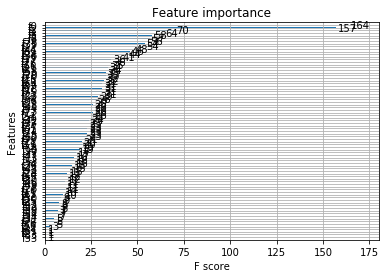

In [37]:
plt.figure(figsize=(15,10))
xgb.plot_importance(bst)

In [38]:
scores = bst.get_fscore()

In [39]:
scores = pd.DataFrame.from_dict(scores,orient='index')
scores = scores.reset_index()
scores.columns = ['Features','score']

In [40]:
scores['Features'] = scores['Features'].apply(lambda x: x.split('f')[1])

In [41]:
scores['Features'] = scores['Features'].astype(int)

In [42]:
columns_df = pd.DataFrame(final_features.columns,columns=['feature'])
columns_df['Features'] = columns_df.index

In [43]:
scores = scores.merge(columns_df,on='Features',how='left')

In [44]:
scores = scores.sort_values(by='score',ascending=False)
scores = scores.reset_index()
scores = scores.drop(['index','Features'],axis=1)
scores = scores[['feature','score']]

In [45]:
scores.to_csv(r'C:\Users\andre_\OneDrive\Documentos\Feature Selection\Importance_Tree.csv')

## Full Generation of Features

Here, the features created above are generated for all the data.

### Functions

In [46]:
def get_manual_features(feature_data):

    index = feature_data.index
    features = ['T', 'CLCT', 'U_100m','V_100m','U_10m','V_10m']

    # Wind Speed Vector
    feature_data['Wind Speed 100m'] = np.sqrt(feature_data['U_100m']**2 + feature_data['V_100m']**2)
    feature_data['Wind Direction 100m'] = np.arctan(feature_data['V_100m']/feature_data['U_100m'])
    feature_data['Wind Speed 10m'] = np.sqrt(feature_data['U_10m']**2 + feature_data['V_10m']**2)
    feature_data['Wind Direction 10m'] = np.arctan(feature_data['V_10m']/feature_data['U_10m'])

    feature_data['Wind Direction 100m'] = feature_data['Wind Direction 100m'].apply(lambda x: 360 + x if x < 0 else x)
    feature_data['Wind Direction 10m'] = feature_data['Wind Direction 10m'].apply(lambda x: 360 + x if x < 0 else x)

    # Time Relative Variables 

    for column in features:
        feature_data[column + '_lag_7_days'] = feature_data[column].shift(7)
        feature_data[column + '_lag_14_days'] = feature_data[column].shift(14)
        feature_data[column + '_lag_21_days'] = feature_data[column].shift(21)

    feature_data['Month_Number'] = feature_data.index.month # Month Number

    mean_month = feature_data.groupby('Month_Number').mean()[features]
    variance_month = feature_data.groupby('Month_Number').var()[features]

    mean_month.columns = mean_month.columns + '_Last_Month_Mean'
    variance_month.columns = variance_month.columns + 'Last_Month_Variance'

    month_data = mean_month.merge(variance_month,on='Month_Number',how='left')
    month_data = month_data.reset_index()
    month_data['Month_Number'] = month_data['Month_Number'] + 1
    month_data['Month_Number'] = month_data['Month_Number'].replace({13:1})

    feature_data = feature_data.merge(month_data,on='Month_Number',how='left')
    feature_data.index = index

    # Periodical Features

    day = feature_data.index.day
    hour = feature_data.index.hour
    minute = feature_data.index.minute
    dayofweek = feature_data.index.dayofweek
    dayofyear = feature_data.index.dayofyear
    days_in_month = feature_data.index.days_in_month

    feature_data["cos_day"], feature_data["sin_day"] = (
    np.cos(2 * np.pi * (day - 1) / days_in_month),
    np.sin(2 * np.pi * (day - 1) / days_in_month),
    )

    feature_data["cos_hour"], feature_data["sin_hour"] = (
        np.cos(2 * np.pi * hour / 24),
        np.sin(2 * np.pi * hour / 24),
        )

    feature_data["cos_minute"], feature_data["sin_minute"] = (
        np.cos(2 * np.pi * minute / 60),
        np.sin(2 * np.pi * minute / 60),
    )

    feature_data["cos_dayofyear"], feature_data["sin_dayofyear"] = (
        np.cos(2 * np.pi * (dayofyear - 1) / 365),
        np.sin(2 * np.pi * (dayofyear - 1) / 365),
    )

    feature_data["cos_dayofweek"], feature_data["sin_dayofweek"] = (
        np.cos(2 * np.pi * dayofweek / 7),
        np.sin(2 * np.pi * dayofweek / 7),
    )

    # Distance from Max and Min

    for column in features:
        feature_data[column + '_Distance_Max'] = feature_data.index - feature_data[column].idxmax()
        feature_data[column + '_Distance_Min'] = feature_data.index - feature_data[column].idxmin()
        feature_data[column + '_Distance_Max'] = feature_data[column + '_Distance_Max'].apply(lambda x : x.days)
        feature_data[column + '_Distance_Min'] = feature_data[column + '_Distance_Min'].apply(lambda x : x.days)

    # Rolling Window Statistics

    for column in features:
        feature_data[column + '_Rolling_7_Window_Mean'] = feature_data[column].rolling(window=7).mean()
        feature_data[column + '_Rolling_14_Window_Mean'] = feature_data[column].rolling(window=14).mean()
        feature_data[column + '_Rolling_7_Window_Variance'] = feature_data[column].rolling(window=7).var()
        feature_data[column + '_Rolling_14_Window_Variance'] = feature_data[column].rolling(window=14).var()

    # Expanded Window Statistics

    for column in features:
        #feature_data[column + '_Expanded_Window_Min'] = feature_data[column].expanding().min()
        feature_data[column + '_Expanded_Window_Max'] = feature_data[column].expanding().max()


    # Dropping Base Features 
    #features.append(['Month_Number','Quarter Number'])
    feature_data = feature_data.drop(features,axis=1)

    return feature_data

In [47]:
def get_features_data(X): 
    feature_data = pd.DataFrame()
    for WF in X['WF'].unique():
        X_WF = X[X['WF']==WF]

        X_WF = get_manual_features(X_WF)

        X_WF['WF'] = WF
        feature_data = pd.concat([feature_data,X_WF],axis=0)

    feature_data = pd.concat([X,feature_data],axis=1) 

    return feature_data

### Process Aplication

In [48]:
X,y_train = get_simplified_data()

X_train = X[X['Set']=='Train']
X_test = X[X['Set']=='Test']

In [49]:
X_train = get_features_data(X_train)
X_test = get_features_data(X_test)

In [50]:
X_train['Set'] = 'Train'
X_test['Set'] = 'Test'

feature_data = pd.concat([X_train,X_test],axis=0)

feature_data = feature_data.loc[:,~feature_data.columns.duplicated()]


feature_data.to_csv(r'C:\Users\andre_\OneDrive\Documentos\Feature Selection\Selected_Features_Data.csv')